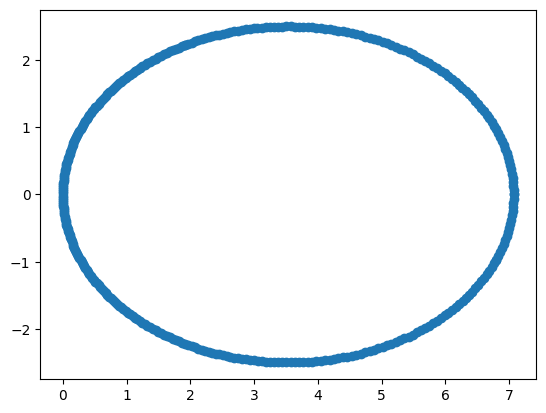

In [4]:
import math
import matplotlib.pyplot as plt


def f(angle):
    a = 5
    denom = 1 + math.sin(angle) ** 2
    r = (a * math.sqrt(2) * math.cos(angle)) / denom
    x = r * math.cos(angle)
    y = r * math.sin(angle)
            
    return x,y
x=[]
y =[]           
for i in range(360):
    a,b = f(i)
    x.append(a)
    y.append(b)
plt.scatter(x,y)
plt.show()

C:\Users\etudiant\AppData\Local\Temp\ipykernel_13892\3256907813.py:6: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(a**2 * np.cos(2*theta))


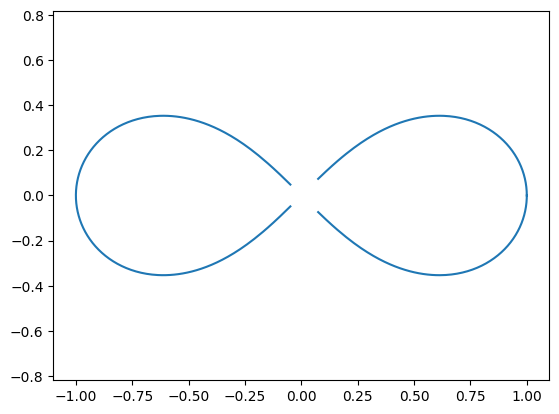

In [5]:
import numpy as np
import matplotlib.pyplot as plt

theta = np.linspace(0, 2*np.pi, 1000)
a = 1
r = np.sqrt(a**2 * np.cos(2*theta))

# On ne garde que les points où r est réel
valid = np.where(np.isreal(r))
theta = theta[valid]
r = r[valid]

x = r * np.cos(theta)
y = r * np.sin(theta)

plt.plot(x, y)
plt.axis('equal')
plt.show()

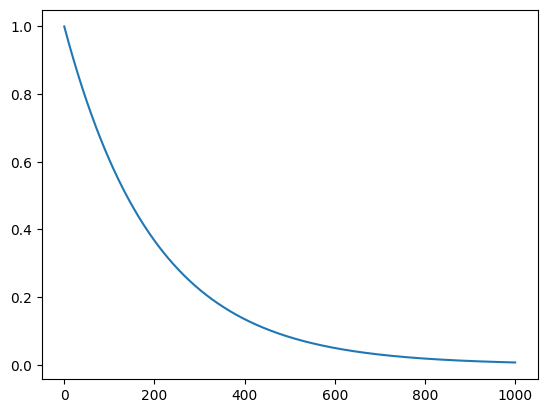

In [6]:
epsilon0 = 1
def f(epsilon):
    return epsilon * 0.995

epsilon =[epsilon0]
for i in range(1000):
    epsilon.append(f(epsilon[i]))
    
import matplotlib.pyplot as plt

plt.plot(epsilon)
plt.show()

In [7]:
epsilon[100]

0.6057704364907278

In [8]:
0.995**120

0.5479862854900421

In [9]:
import numpy as np
num_types = 13
state = np.zeros((num_types,), dtype=np.float32)

In [10]:
state

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
import json

with open("viewer/data/output.json", "r") as f:
    data = json.load(f)


In [12]:
# Exemple: afficher la frame 0
frame = data[0]

for step in frame:
    print("Action:", step["action"])
    print("Facing:", step["facing"])
    print("Agent Pos:", step["agent"]["x"], step["agent"]["y"])
    print("Objets visibles:")
    for obj in step["visible"]:
        print(" -", obj["type"], f"at ({obj['x']}, {obj['y']})")


Action: {'type': 'move', 'dx': 1.8484110785501702, 'dy': 0.7637908644995669}
Facing: {'x': 51.84841107855017, 'y': 30.763790864499565, 'angle': 0.3918463070298718, 'length': 45, 'fov': 2.0943951023931953}
Agent Pos: 51.84841107855017 30.763790864499565
Objets visibles:
 - target at (25, 85)
 - target at (85, 25)
 - energy at (15, 15)
 - energy at (25, 65)
 - energy at (65, 25)
 - energy at (50, 50)
 - mine at (40, 50)
 - mine at (60, 50)
 - mine at (50, 40)
 - mine at (50, 60)
 - mine at (30, 80)
 - mine at (80, 30)
 - enemy_drone at (22.546479089470324, 25.0)
 - enemy_drone at (69.95004165278026, 55.99833416646828)
 - enemy_drone at (35.22726353015205, 71.0596187758103)
 - enemy_drone_elite at (80.34612300385429, 30.314610417509115)
 - enemy_drone_elite at (24.997004035598824, 25.00692223416505)
 - enemy_turret at (35, 85)
 - enemy_turret at (85, 35)
 - enemy_kamikaze at (20, 70)
 - enemy_kamikaze at (25, 70)
 - enemy_kamikaze at (30, 70)
 - enemy_kamikaze at (70.17888543819998, 19.91

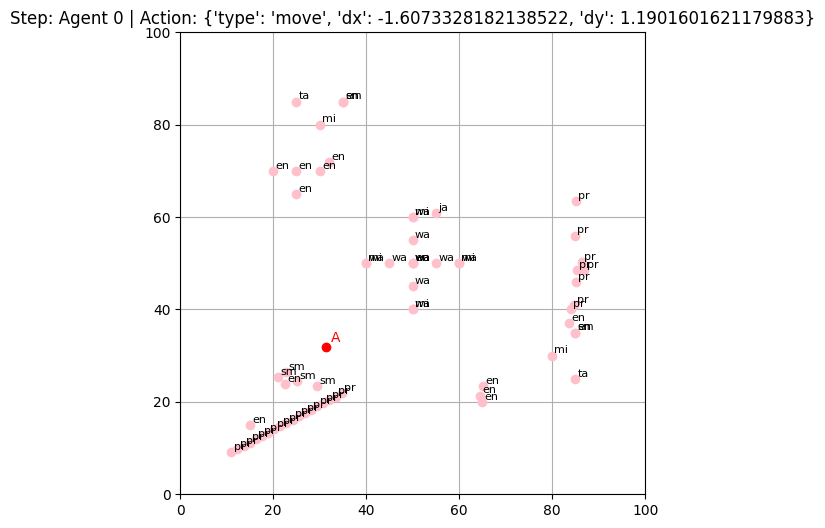

In [13]:
import matplotlib.pyplot as plt

def plot_frame(frame, agent_index=0, width=100, height=100):
    step = frame[agent_index]
    agent = step["agent"]
    visibles = step["visible"]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_title(f"Step: Agent {agent_index} | Action: {step['action']}")

    # Agent
    ax.plot(agent["x"], agent["y"], 'ro', label="Agent")
    ax.annotate("A", (agent["x"]+1, agent["y"]+1), color='r')

    # Objets visibles
    for obj in visibles:
        ox, oy = obj["x"], obj["y"]
        cls = obj["type"]
        color = {
            "EnergyDrone": "blue",
            "Energy": "green",
            "Projectile": "black",
            "JammerZone": "purple",
            "SmokeZone": "gray",
            "Target": "gold",
            "Decoy": "orange",
            "Agent": "red"
        }.get(cls, "pink")
        
        ax.plot(ox, oy, 'o', color=color, label=cls)
        ax.annotate(cls[:2], (ox+0.5, oy+0.5), fontsize=8)


    plt.grid()
    plt.show()

# Exemple
plot_frame(data[50])


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Nouveau mapping complet (14 canaux)
channels = {
    "agent": 0,
    "enemy_drone": 1,
    "enemy_kamikaze": 2,
    "energy": 3,
    "mine": 4,
    "enemy_drone_elite": 5,
    "enemy_turret": 6,
    "target": 7,
    "jammer": 8,  # smoke inclus ici
    "smoke": 8,
    "jammer_comunication": 9,
    "wall": 10,
    "facing": 11 , # canal spécial 🧭
    "projectile":12,
    "decoy":13
    
}


channel_names = [
    "Agent", "Enemy Drone", "Kamikaze", "Energy", "Mine", "Drone Elite",
    "Turret", "Target", "Jammer/Smoke", "Jammer Com", "Wall", "Regard","projectile"  ,"decoy"
]

def extract_minimap_tensor(step, grid_size=32):
    num_channels = len(channel_names)
    tensor = np.zeros((num_channels, grid_size, grid_size), dtype=np.float32)

    agent = step["agent"]
    facing = step.get("facing", {})
    ax, ay = agent["x"], agent["y"]
    vision_range = agent.get("range", 45)
    angle = facing.get("angle", 0.0)
    fov = facing.get("fov", 2 * math.pi)

    cell_size = (2 * vision_range) / grid_size
    center = grid_size // 2

    def to_grid_coords(x, y):
        dx = x - ax
        dy = y - ay
        gx = int((dx + vision_range) / cell_size)
        gy = int((dy + vision_range) / cell_size)
        return gx, gy

    def in_fov(ox, oy):
        dx, dy = ox - ax, oy - ay
        dist = math.sqrt(dx**2 + dy**2)
        if dist > vision_range:
            return False
        angle_to_obj = math.atan2(dy, dx)
        delta_angle = (angle_to_obj - angle + math.pi) % (2 * math.pi) - math.pi
        return abs(delta_angle) <= fov / 2

    # Agent au centre
    tensor[channels["agent"], center, center] = 1.0


    # Encode direction de regard
    facing = step.get("facing", {})
    angle = facing.get("angle", 0.0)
    length = grid_size // 2

    for i in range(1, length):
        dx = math.cos(angle) * i
        dy = math.sin(angle) * i
        gx = int(center + dx)
        gy = int(center + dy)
        if 0 <= gx < grid_size and 0 <= gy < grid_size:
            tensor[channels["facing"], gy, gx] = 1.0 - (i / length)

    # Objets visibles
    for obj in step.get("visible", []):
        ox, oy = obj["x"], obj["y"]
        cls = obj.get("type")
        radius = obj.get("radius", 1.0)

        if cls not in channels or not in_fov(ox, oy):
            continue

        gx, gy = to_grid_coords(ox, oy)
        ch = channels[cls]
        radius_cells = max(1, int(radius / cell_size))

        for dx in range(-radius_cells, radius_cells + 1):
            for dy in range(-radius_cells, radius_cells + 1):
                x, y = gx + dx, gy + dy
                if 0 <= x < grid_size and 0 <= y < grid_size:
                    if dx**2 + dy**2 <= radius_cells**2:
                        tensor[ch, y, x] = 1.0


    return tensor



In [15]:
import numpy as np
import math

# Mapping des canaux
channels = {
    "agent": 0,
    "enemy_drone": 1,
    "enemy_kamikaze": 2,
    "energy": 3,
    "mine": 4,
    "enemy_drone_elite": 5,
    "enemy_turret": 6,
    "target": 7,
    "jammer": 8,
    "smoke": 8,
    "jammer_comunication": 9,
    "wall": 10,
    "facing": 11,
    "heatmap_danger": 12,
    "heatmap_energy": 13,
    "projectile": 14,
    "decoy": 15,
}

channel_names = [
    "Agent", "Enemy Drone", "Kamikaze", "Energy", "Mine", "Drone Elite",
    "Turret", "Target", "Jammer/Smoke", "Jammer Com", "Wall", "Regard",
    "Heatmap Danger", "Heatmap Énergie", "Projectile", "Decoy"
]

def extract_minimap_tensor(step, grid_size=32):
    num_channels = len(channel_names)
    tensor = np.zeros((num_channels, grid_size, grid_size), dtype=np.float32)

    agent = step["agent"]
    facing = step.get("facing", {})
    ax, ay = agent["x"], agent["y"]
    vision_range = agent.get("range", 45)
    angle = facing.get("angle", 0.0)
    fov = facing.get("fov", 2 * math.pi)

    cell_size = (2 * vision_range) / grid_size
    center = grid_size // 2

    def to_grid_coords(x, y):
        dx = x - ax
        dy = y - ay
        gx = int((dx + vision_range) / cell_size)
        gy = int((dy + vision_range) / cell_size)
        return gx, gy

    def in_fov(ox, oy):
        dx, dy = ox - ax, oy - ay
        dist = math.sqrt(dx**2 + dy**2)
        if dist > vision_range:
            return False
        angle_to_obj = math.atan2(dy, dx)
        delta_angle = (angle_to_obj - angle + math.pi) % (2 * math.pi) - math.pi
        return abs(delta_angle) <= fov / 2

    # Agent au centre
    tensor[channels["agent"], center, center] = 1.0

    # Encode le regard
    length = grid_size // 2
    for i in range(1, length):
        dx = math.cos(angle) * i
        dy = math.sin(angle) * i
        gx = int(center + dx)
        gy = int(center + dy)
        if 0 <= gx < grid_size and 0 <= gy < grid_size:
            tensor[channels["facing"], gy, gx] = 1.0 - (i / length)

    # Objets visibles
    for obj in step.get("visible", []):
        ox, oy = obj["x"], obj["y"]
        cls = obj.get("type")
        radius = obj.get("radius", 1.0)

        if cls not in channels or not in_fov(ox, oy):
            continue

        gx, gy = to_grid_coords(ox, oy)
        ch = channels[cls]
        radius_cells = max(1, int(radius / cell_size))

        # Valeur par défaut
        value = 1.0

        # Pondération par propriété
        if "health" in obj:
            value = obj["health"] / 100.0
        elif cls == "energy":
            energy = obj.get("energy", 0.0)
            value = min(1.0, energy / 150.0)
        elif cls == "mine":
            value = 0.9
        elif cls in ["projectile", "decoy"]:
            value = 0.7

        # Écriture dans le canal de classe
        for dx in range(-radius_cells, radius_cells + 1):
            for dy in range(-radius_cells, radius_cells + 1):
                x, y = gx + dx, gy + dy
                if 0 <= x < grid_size and 0 <= y < grid_size:
                    if dx**2 + dy**2 <= radius_cells**2:
                        tensor[ch, y, x] = max(tensor[ch, y, x], value)

                        # Canal danger (ennemis, mines)
                        if cls in ["enemy_drone", "enemy_kamikaze", "enemy_turret", "mine", "enemy_drone_elite"]:
                            tensor[channels["heatmap_danger"], y, x] = max(tensor[channels["heatmap_danger"], y, x], value)

                        # Canal énergie
                        if cls == "energy":
                            tensor[channels["heatmap_energy"], y, x] = max(tensor[channels["heatmap_energy"], y, x], value)

    return tensor


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Palette RGB personnalisée pour chaque canal
color_map = {
    0: [0.2, 0.6, 1.0],    # Agent
    1: [1.0, 0.0, 0.0],    # Enemy Drone
    2: [1.0, 0.3, 0.0],    # Kamikaze
    3: [0.0, 1.0, 0.0],    # Energy
    4: [0.5, 0.3, 0.1],    # Mine
    5: [1.0, 0.0, 1.0],    # Drone Elite
    6: [0.6, 0.6, 0.0],    # Turret
    7: [0.0, 1.0, 1.0],    # Target
    8: [0.4, 0.4, 0.4],    # Jammer/Smoke
    9: [1.0, 1.0, 0.0],    # Jammer com
    10: [0.0, 0.0, 0.0],   # Wall
    11: [1.0, 1.0, 1.0],   # Regard 🧭
    10: [0.4, 0.7, 0.3],   # projectille
    11: [1.0, 1.0, 1.0],   # 
}

def tensor_to_rgb(tensor):
    H, W = tensor.shape[1], tensor.shape[2]
    rgb = np.zeros((H, W, 4), dtype=np.float32)  # RGBA

    for ch in range(tensor.shape[0]):
        color = color_map.get(ch, [1.0, 1.0, 1.0])
        mask = tensor[ch]
        for c in range(3):  # R, G, B
            rgb[:, :, c] += mask * color[c]
        rgb[:, :, 3] += mask  # alpha channel (transparence)

    rgb = np.clip(rgb, 0, 1)
    return rgb

def show_minimap(tensor, title_prefix="Channel"):
    C = tensor.shape[0]
    grid_cols = 4
    total_plots = C + 2  # +1 for mean, +1 for RGB fusion
    grid_rows = int(np.ceil(total_plots / grid_cols))

    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    axs = axs.flatten()

    for i in range(C):
        ax = axs[i]
        ax.imshow(tensor[i], cmap='viridis', interpolation='nearest')
        if i < len(channel_names):
            ax.set_title(channel_names[i], fontsize=12)
        else:
            ax.set_title(f"{title_prefix} {i}", fontsize=12)
        ax.axis('off')

    # Image moyenne
    ax = axs[C]
    ax.imshow(tensor.mean(axis=0), cmap='inferno', interpolation='nearest')
    ax.set_title("Mean Activation", fontsize=12)
    ax.axis('off')

    # RGB fusion avec transparence
    rgb = tensor_to_rgb(tensor)
    ax = axs[C + 1]
    ax.imshow(rgb)
    ax.set_title("RGB Fusion Overlay", fontsize=12)
    ax.axis('off')

    # Masque les axes restants
    for j in range(C + 2, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


In [17]:
len(data[1])

7

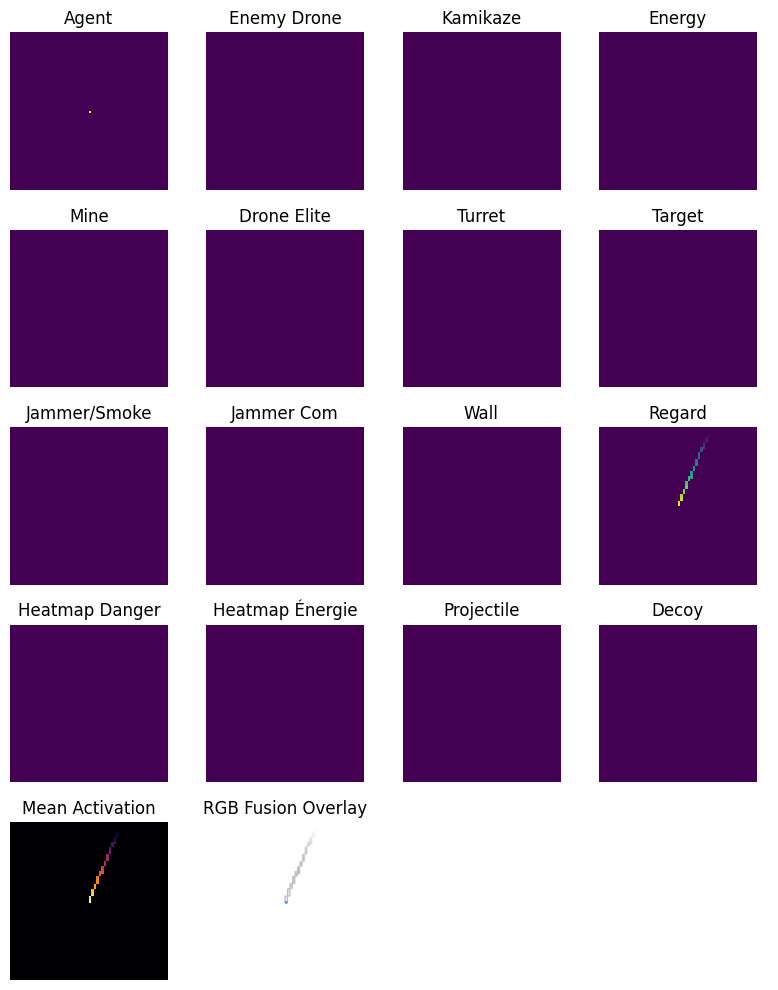

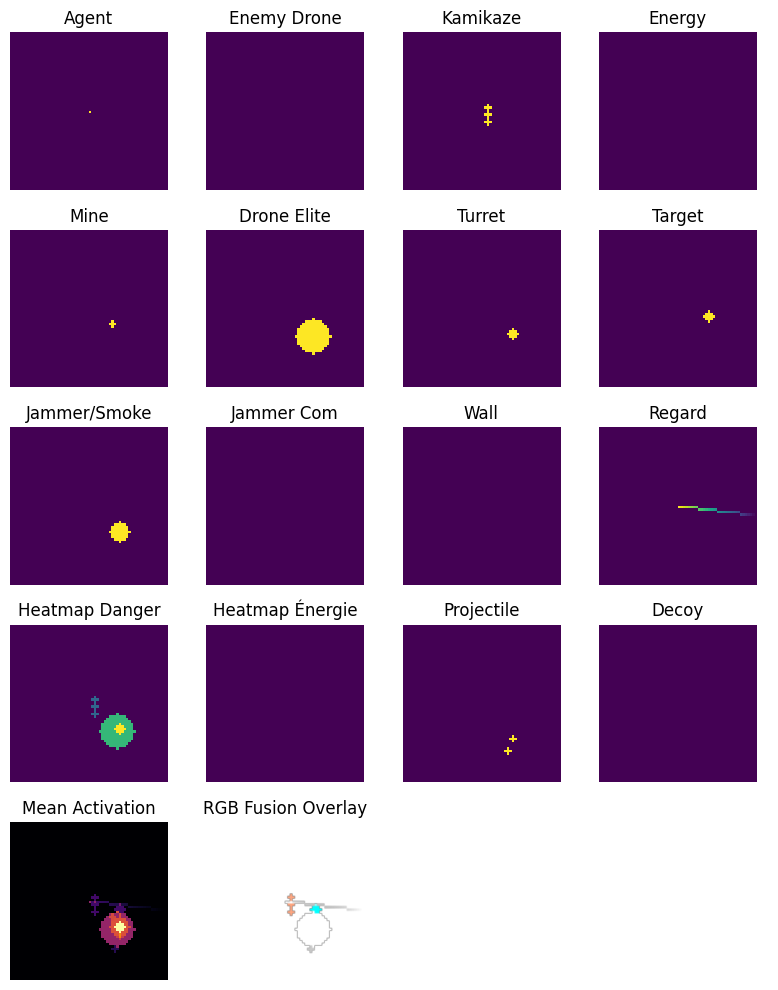

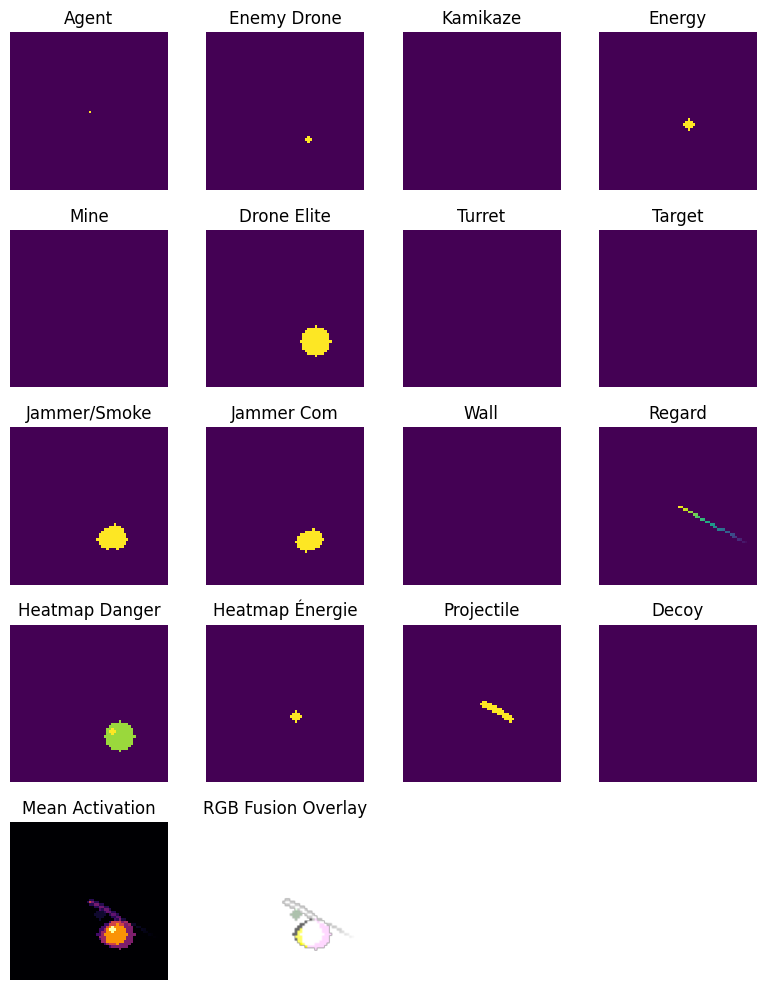

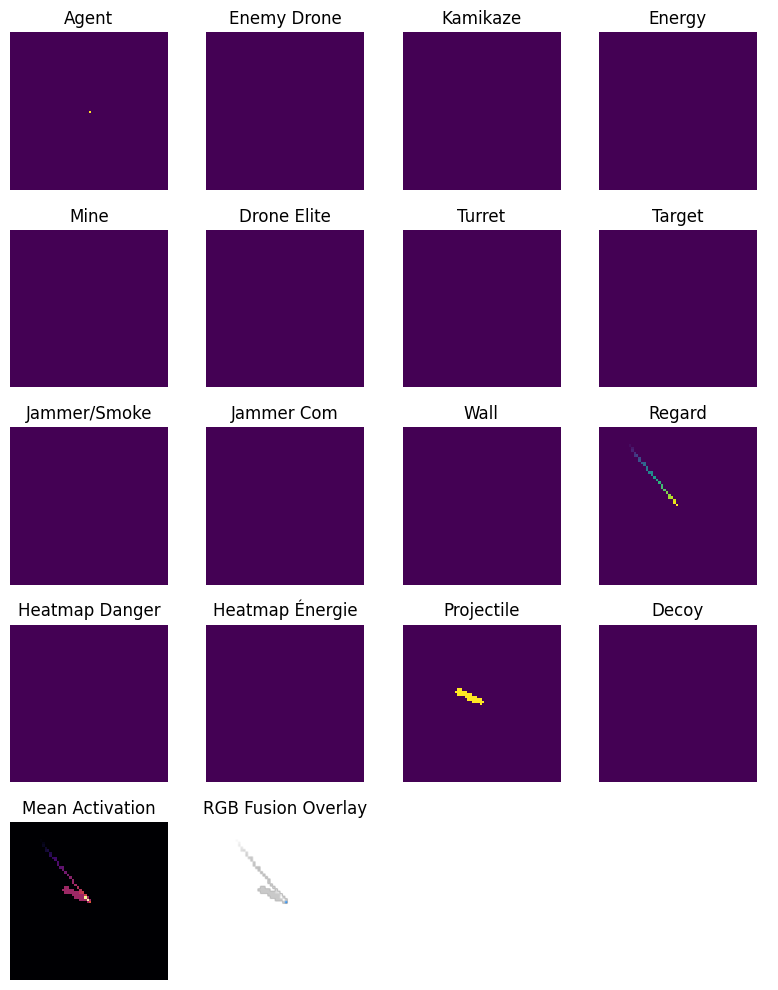

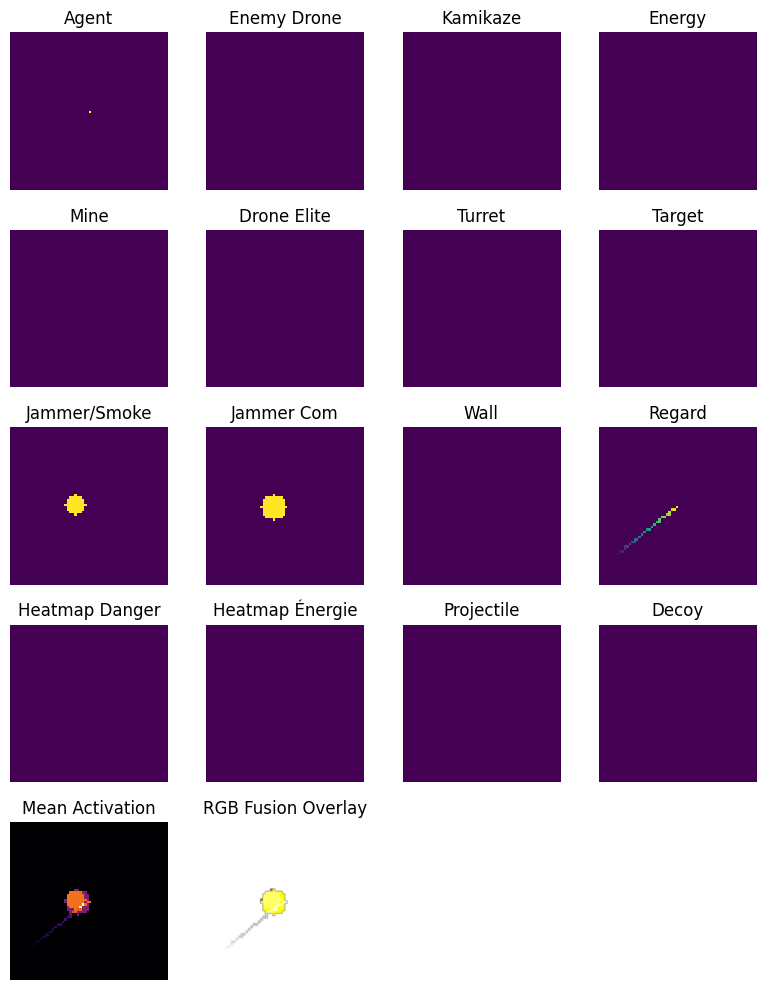

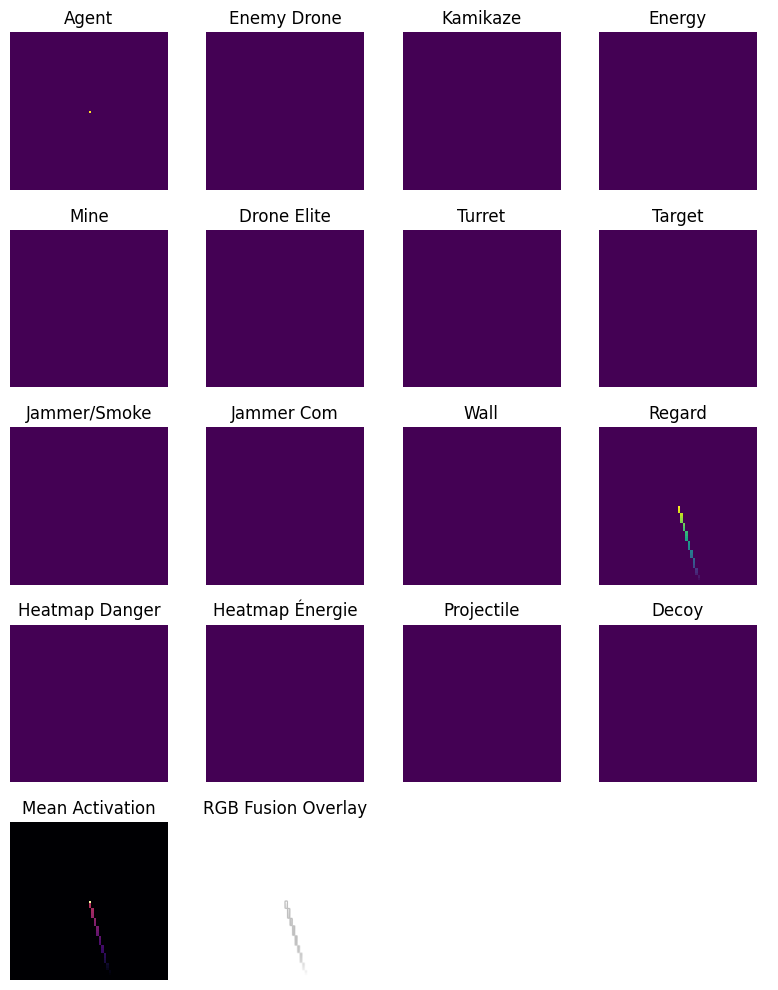

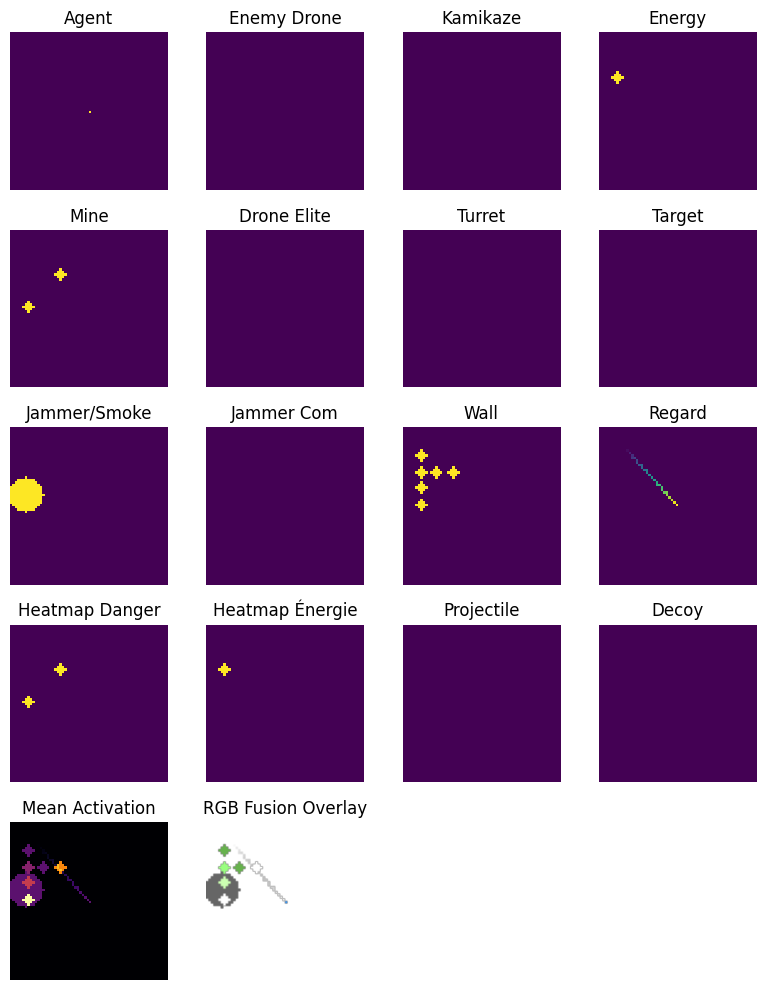

In [18]:
for agent in range(len(data[1])):
    agent_frame = data[20][agent]
    tensor = extract_minimap_tensor(agent_frame, grid_size=64)
    show_minimap(tensor)


In [19]:
b = np.array([2,2])
b =np.clip(np.array([1,2]), 0, 1)
b

array([1, 1])

In [20]:
len(data)

1000